## Rank based on Brand Growth and Exposure 
This notebook produces a dataframe of merchant rankings based on metrics that maximize the BNPL firm's brand growth and exposure. Now that we have considered the financial aspect of maximizing revenue as well as the demographic aspect of customers, we also want to incorportate a marketing aspect into our ranking system. In this section, we will focus on metrics that will help promote our BNPL firm's brand growth and exposure. We believe that onboarding merchants who maximize the metrics below will help our firm to expand and grow.

1. Sales Region Count 
2. Returning Customers Count
3. Consumer Base
    
Justifications and explanations on these metric choices can be found below, throughout the notebook.

In [3]:
# import libraries and constants
import sys
sys.path.append('../scripts/utils')
from constants import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# create a spark session 
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 13:53:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# read data
tbl_merchants = pd.read_pickle(f"{CURATED_DATA}tbl_merchants.pkl")
tbl_consumers = pd.read_pickle(f"{CURATED_DATA}tbl_consumer.pkl")
transactions = spark.read.parquet(f"{TRANSACTION_DATA}")

# join to get transactions with merchants and consumers details
transactions_joined = transactions.join(spark.createDataFrame(tbl_consumers), on="user_id", how="inner") 
transactions_joined = transactions_joined.withColumnRenamed("name", "con_name")
transactions_joined = transactions_joined.join(spark.createDataFrame(tbl_merchants), on="merchant_abn", how="inner")
transactions_joined = transactions_joined.withColumnRenamed("name", "mer_name")

# create dataframe to store ranking
ranking_df = pd.DataFrame(sorted(list(tbl_merchants["merchant_abn"])), columns=['merchant_abn'])

### 1. Sales Region Count

  *  We would like to onboard merchants who sells to as many postcodes as possible.
  * We believe this reflects the geographical reach of each merchant.
  * <b>Market Expansion</b>: Onboarding merchants with a broad geographical reach allows our BNPL firm to expand its market coverage. This means reaching more potential customers in different areas, including urban and rural locations. By partnering with merchants in various postcodes, the BNPL firm can tap into previously untapped markets and increase its customer base.
  * <b>Diversification</b>: Working with merchants from diverse locations can help the BNPL firm diversify its risk. Different regions may have varying economic conditions and customer behavior. By having a presence in multiple postcodes, the BNPL firm can spread its risk and reduce its exposure to economic fluctuations or market-specific challenges in a single area.
  * <b>Enhanced Customer Base</b>: A wide geographical reach helps in acquiring a diverse customer base. People in different postcodes have different purchasing habits and preferences. Onboarding merchants from various regions ensures that the BNPL firm can cater to a wide range of customer needs and preferences.

In [6]:
# calculate number of postcodes reached by each merchant
postcode_per_merchant = transactions_joined.groupBy("merchant_abn").agg(
    F.countDistinct("postcode").alias("postcode_count")
).orderBy("merchant_abn").toPandas()

ranking_df = ranking_df.merge(postcode_per_merchant, on='merchant_abn', how='left')

23/10/19 13:54:03 WARN TaskSetManager: Stage 2 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


### 2. Returning Customers Count

  * We would like to onboard merchants with a high number of returning customers.
  * We define returning customers as customers who have made >1 transactions with the particular merchant.
  * <b>Brand Credibility</b>: Merchants with a strong base of returning customers have likely built a reputation for quality, trustworthiness, and customer satisfaction. By aligning with such merchants, the BNPL firm can benefit from the positive image and credibility associated with these businesses. This can help the enhance our brand image.
  * <b>Market Presence</b>: Merchants with high returning customer numbers often have a strong market presence and reach. Partnering with these merchants allows the BNPL firm to tap into the existing customer base of these businesses. This can lead to an immediate and broad market penetration, reaching a wide audience with established purchasing habits.
  * <b> Stable Revenue Streams </b>: Returning customers are more likely to make frequent purchases, creating a stable and predictable revenue stream for both the merchant and the BNPL firm. This stability can be beneficial in terms of financial planning and risk management.

In [7]:
# calculate number of returning customers
user_purchases = transactions_joined.groupBy('merchant_abn', 'user_id').agg(
    F.count('order_id').alias('num_purchases'))

return_customers = user_purchases.groupBy('merchant_abn').agg(
    F.countDistinct(
        F.when(F.col('num_purchases') > 1, F.col('user_id'))
    ).alias('returning_customers')).toPandas()

ranking_df = ranking_df.merge(return_customers, on='merchant_abn', how='left')

23/10/19 13:54:29 WARN TaskSetManager: Stage 23 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


### 3. Consumer Base
  * We would like to onboard merchants with a large consumer base.
  * That is, onboarding merchants with a large number of unique customers.
  * <b> Market Expansion </b>: Merchants with a large and diverse customer base can help the BNPL firm expand into new markets and demographics. By serving a wide range of unique customers, the BNPL firm can reach customers with varying preferences, purchasing habits, and needs.
  * <b> Customer Acquisition </b>: Partnering with high-customer-traffic merchants allows the BNPL firm to acquire new customers. Unique customers who haven't used the BNPL service before represent an opportunity for the firm to introduce its payment option and potentially convert them into long-term users.
  * <b>Brand Exposure</b>: Collaborating with high-traffic merchants can enhance the visibility and credibility of the BNPL service. These merchants may have strong brand recognition, and associating with them can build trust and awareness among consumers who may not have previously been familiar with the BNPL service.

In [8]:
# calculate number of customers
number_customers = transactions_joined.groupBy("merchant_abn").agg(
    F.countDistinct("user_id").alias("customer_base")
).orderBy("merchant_abn").toPandas()

ranking_df = ranking_df.merge(number_customers, on='merchant_abn', how='left')

23/10/19 13:54:46 WARN TaskSetManager: Stage 35 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


### Rank
Now, we will combine these three metrics in order to rank merchants.
  * The three metrics will be equally weighted
  * The three metrics will be normalized before ranking

In [9]:
# ensure no null values
ranking_df = ranking_df.dropna()

# normalize 
def normalize_column(column: pd.Series) -> pd.Series:
    '''
    Normalize a series.
    Arguments:
      - column = series to be normalized
    Output:
      - the normalized series
    '''

    min_value = column.min()
    max_value = column.max()
    return (column - min_value) / (max_value - min_value)

normalized_columns = ranking_df.drop(columns=['merchant_abn']).apply(normalize_column)
ranking_df = pd.concat([ranking_df['merchant_abn'], normalized_columns], axis=1)

In [10]:
# create new column
ranking_df["metric"] = 1/3*ranking_df["postcode_count"] + 1/3*ranking_df["returning_customers"] + 1/3*ranking_df["customer_base"]

# sort, then rank
ranking_df = ranking_df.sort_values(by='metric', ascending=False)
ranking_df['rank'] = range(1, len(ranking_df) + 1)
ranking_df = ranking_df.sort_values(by='merchant_abn')
ranking_df = ranking_df.reset_index(drop=True)

# save to analysis layer
ranking_df.to_pickle(f"{ANALYSIS_DATA}brand_exposure_ranking.pkl")

ranking_df

,merchant_abn,postcode_count,returning_customers,customer_base,metric,rank
0,10023283211,0.613148,0.009054,0.125872,0.249358,763
1,10142254217,0.597029,0.007558,0.118272,0.240953,794
2,10165489824,0.001264,0.000000,0.000166,0.000477,3957
3,10187291046,0.099241,0.000042,0.013870,0.037718,2171
4,10192359162,0.113780,0.000083,0.015864,0.043242,2066
...,...,...,...,...,...,...
4017,99938978285,0.982301,0.164749,0.514618,0.553889,148
4018,99974311662,0.039507,0.000000,0.005357,0.014955,2807
4019,99976658299,0.993995,0.251381,0.618771,0.621382,100
4020,99987905597,0.057522,0.000083,0.007807,0.021804,2558


### Brief Analysis
We perform some quick analysis on the output of the rankings. Below are some findings:
  * A large proportion of merchants (34.54%) have zero returning customers, hence explaining the tail in the second plot.
  * Otherwise, the ranking looks pretty consistent with the individual metrics.

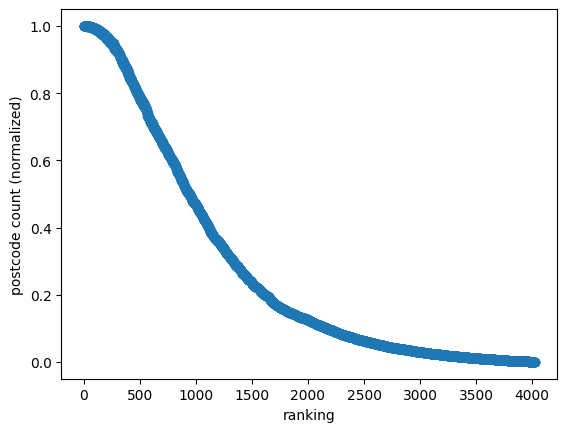

In [11]:
# plot to see how postcode count changes as ranking increases
plt.scatter(ranking_df['rank'], ranking_df['postcode_count'])
plt.ylabel("postcode count (normalized)")
plt.xlabel("ranking")
plt.show()

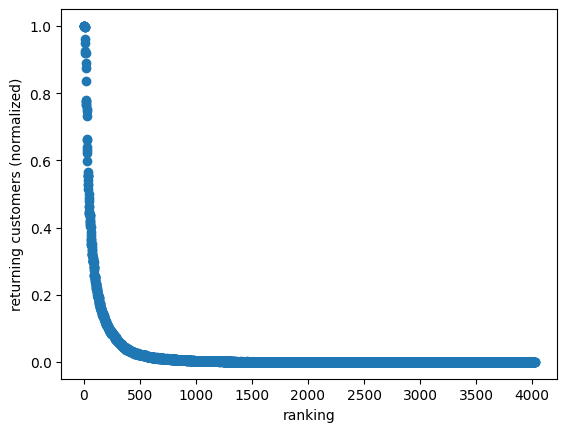

In [12]:
# plot to see how number of returning customers changes as ranking increases
plt.scatter(ranking_df['rank'], ranking_df['returning_customers'])
plt.ylabel("returning customers (normalized)")
plt.xlabel("ranking")
plt.show()

In [13]:
zero_return = len(ranking_df[ranking_df['returning_customers']==0])
print(f"There are {zero_return} or {zero_return/len(ranking_df)*100:.2f}% of merchants that have zero returning customers")

There are 1393 or 34.63% of merchants that have zero returning customers


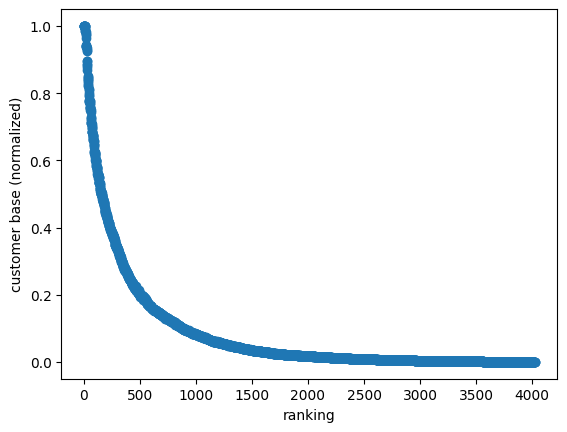

23/10/19 14:23:14 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 500647 ms exceeds timeout 120000 ms
23/10/19 14:23:14 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/19 14:23:18 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [14]:
# plot to see how number of customers changes as ranking increases
plt.scatter(ranking_df['rank'], ranking_df['customer_base'])
plt.ylabel("customer base (normalized)")
plt.xlabel("ranking")
plt.show()